In [1]:
import numpy as np
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.utils import *
import pandas as pd

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


In [3]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [4]:
X_word_tr, X_char_tr, y_tr, idx_word_tr, idx_tag_tr = wc_input_converter(merged_data, train_data)
X_word_val, X_char_val, y_val, idx_word_val, idx_tag_val = wc_input_converter(merged_data, val_data)
X_word_ts, X_char_ts, y_ts, idx_word_ts, idx_tag_ts = wc_input_converter(merged_data, test_data)

In [5]:
df = list_to_dataframe(merged_data)

In [6]:
words = get_unique_words(df)
tags = get_unique_tags(df)
chars = set([w_i for w in words for w_i in w])

In [7]:
num_words = len(words)
num_tags = len(tags)
num_char = len(chars)
max_len = 100
max_len_char = 10

In [9]:
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Flatten
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.initializers import RandomUniform

def wc_cnn_blstm_model(num_words, num_tags, num_char, max_len, max_len_char):
    # word embedding as input
    word_input = Input(shape=(max_len, ))
    word_embd = Embedding(input_dim=num_words + 2, output_dim=50, input_length=max_len)(word_input)

    # character embedding as input
    char_input = Input(shape=(max_len, max_len_char, ))
    char_embd = TimeDistributed(Embedding(input_dim=num_char + 2, output_dim = 10,
                                          input_length=max_len_char,
                                          embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)))(char_input)

    dropout= Dropout(0.5)(char_embd)
    conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=max_len_char, padding='same',activation='tanh', strides=1))(dropout)
    maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
    flat_layer = TimeDistributed(Flatten())(maxpool_out)
    char_encd = Dropout(0.5)(flat_layer)
    # character LSTM to obtain word encodings by characters
    #char_encd = TimeDistributed(LSTM(units=20, return_sequences=False, recurrent_dropout=0.5))(char_embd)

    # main BLSTM stack
    concate = concatenate([word_embd, char_encd])
    spa_dropout_layer = SpatialDropout1D(0.3)(concate)
    blstm_layer = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.3))(spa_dropout_layer)
    out = TimeDistributed(Dense(num_tags + 1, activation='softmax'))(blstm_layer)
    model = Model([word_input, char_input], out)

    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.summary()

    return model

model = wc_cnn_blstm_model(num_words, num_tags, num_char, max_len, max_len_char)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100, 10)]    0           []                               
                                                                                                  
 time_distributed_3 (TimeDistri  (None, 100, 10, 10)  5570       ['input_4[0][0]']                
 buted)                                                                                           
                                                                                                  
 dropout_1 (Dropout)            (None, 100, 10, 10)  0           ['time_distributed_3[0][0]']     
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 100, 10, 10)  310        ['dropout_1[0][0]']          

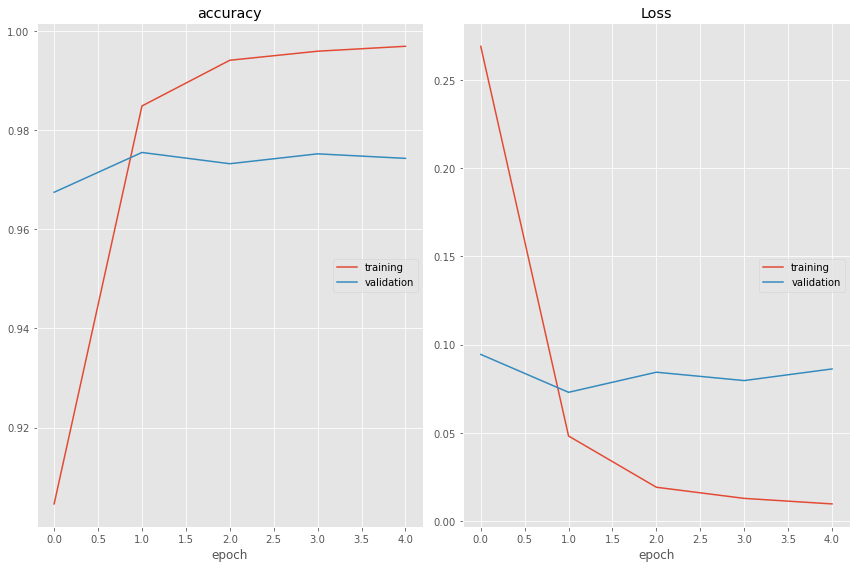

accuracy
	training         	 (min:    0.905, max:    0.997, cur:    0.997)
	validation       	 (min:    0.967, max:    0.975, cur:    0.974)
Loss
	training         	 (min:    0.010, max:    0.269, cur:    0.010)
	validation       	 (min:    0.073, max:    0.094, cur:    0.086)

Epoch 5: val_loss did not improve from 0.07291
56/56 [==============================] - 1s 24ms/step - loss: 0.0835 - accuracy: 0.9751
[0.08346357941627502, 0.9751319289207458]


In [10]:
root_path = 'model/'
model_name = 'wc_cnn_blstm_model.h5'
num_epoch = 5
batch_sz = 32
callbacks = get_callbacks(root_path, model_name)

history = model.fit(x=[X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    y=np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    #validation_data=(X_word_val, y_val),
                    validation_data=(
                      [X_word_val, np.array(X_char_val).reshape((len(X_char_val),
                                                                max_len, max_len_char))],
                        np.array(y_val).reshape(len(y_val), max_len, 1)
                    ),
                    batch_size=batch_sz,
                    epochs=num_epoch,
                    callbacks=callbacks,
                    verbose=1
                    )

print(model.evaluate([X_word_ts, np.array(X_char_ts).reshape((len(X_char_ts), max_len, max_len_char))], np.array(y_ts).reshape(len(y_ts), max_len, 1)))

In [11]:
from keras.models import load_model

mdl = load_model('model/wc_cnn_blstm_model.h5')

In [12]:
predict_val = [X_word_ts, np.array(X_char_ts).reshape((len(X_char_ts), max_len, max_len_char))]

i = np.random.randint(0, X_word_ts.shape[0])
p = mdl.predict(predict_val)

p = np.argmax(p[i], axis=-1)
y_true = y_ts[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)

for w, true, pred in zip(X_word_ts[i], y_true, p):
    if w != 0:
        print("{:30}{:10}\t{}".format(idx_word_ts[w], idx_tag_ts[true], idx_tag_ts[pred]))

Word                          True      	 Pred

------------------------------------------------------------
oyi                           JV        	JV
rek                           JV        	JV
penjual                       ID        	ID
ayam                          ID        	ID
potong                        ID        	ID
di                            ID        	ID
pasar                         ID        	ID
itu                           ID        	ID
mau                           ID        	ID
apa                           ID        	ID
engga                         ID        	ID
ya                            ID        	ID
kalo                          ID        	ID
misal                         ID        	ID
kita                          ID        	ID
beline                        MIX-ID-JV 	MIX-ID-JV
fillet                        EN        	O
?                             O         	O
spill                         EN        	EN
dipasar                       ID        	ID
mana  

In [ ]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_word_ts)):
    p = model.predict([X_word_ts,
                        np.array(X_char_ts).reshape((len(X_char_ts),
                                                     max_len, max_len_char))])
    p = np.argmax(p[i], axis=-1)
    y_true = y_ts[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_word_ts[i], y_true, p):
        if w != 0:
            # print("{:30}{:10}\t{}".format(idx_word[w], idx_tag[true], idx_tag[pred]))
            w_pair.append(idx_word_ts[w])
            true_pair.append(idx_tag_ts[true])
            pred_pair.append(idx_tag_ts[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

In [ ]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

In [ ]:
performance_report(true_flat, pred_flat)

In [ ]:
df_ = pd.DataFrame({
    'word': all_w_pair,
    'true': all_true_pair,
    'pred': all_pred_pair
})

In [ ]:
token_true_pred = []
for index, row in df_.iterrows():
    pair = list(zip(row['word'], row['true'], row['pred']))
    token_true_pred.append(pair)

In [ ]:
true_pred_file = 'tagging_result/wc_cnn_blstm_compare_results.tsv'
with open(true_pred_file, "a", encoding='utf-8') as f:
    f.write("Word" + "\t" + "True" + "\t" + "Predict" + "\n")
    for index, row in df_.iterrows():
        for tkn, t_true, t_pred in (zip(row['word'], row['true'], row['pred'])):
            f.write(tkn + '\t' + t_true + '\t' + t_pred + '\n')
        f.write('\n')

f.close()